# Informações Gerais
- nome do dataset, localização, origem, contexto (do que se trata?)

## Nome

SRAG 2021 - Banco de Dados de Síndrome Respiratória Aguda Grave - incluindo dados da COVID-19

## Localização
- Página com informações completas sobre o conjunto de dados: https://opendatasus.saude.gov.br/dataset/bd-srag-2021
- Dados: https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/2021/INFLUD21-29-03-2021.csv

## Origem e contexto

Desde 2009, com a pandemia de Influenza A(H1N1)pdm09, a Secretaria de Vigilância em Saúde (SVS), vinculada ao Ministério da Saúde, desenvolve a vigilância da Síndrome Respiratória Aguda Grave (SRAG) no Brasil. Em 2020 a vigilância da COVID-19 foi incorporada na rede de vigilância da Influenza e outros vírus respiratórios.

Todos os bancos de dados epidemiológicos de SRAG, desde 2009 até os dias atuais (2021), são disponibilizados no portal https://opendatasus.saude.gov.br. 

O banco de dados "SRAG 2021" contém as informações referentes aos casos de SRAG no com início dos primeiros sintomas no ano de 2021. Atualmente, o sistema oficial para o registro dos casos e óbitos de SRAG no Brasil é o Sistema de Informação da Vigilância Epidemiológica da Gripe (SIVEP-Gripe).


## Informações adicionais

- No Guia de Vigilância Epidemiológica Emergência de Saúde Pública de Importância Nacional pela Doença pelo Coronavírus 2019 estão disponíveis informações sobre definições de casos, critérios de confirmação e encerramento dos casos, dentre outros. [link](https://portalarquivos.saude.gov.br/images/af_gvs_coronavirus_6ago20_ajustes-finais-2.pdf)

- Os dados da vigilância de SRAG no Brasil disponibilizados estão sujeitos a alterações decorrentes da investigação pelas equipes de vigilância epidemiológica que desenvolvem o serviço nas três esferas de gestão.

- Os dados de 2021 são disponibilizados semanalmente, às quartas-feiras, podendo, excepcionalmente, a atualização ocorrer em outro dia.

In [24]:
import os.path
import ssl
from urllib.request import urlopen
from bs4 import BeautifulSoup
from IPython.display import HTML, Image

import dataframe_image as dfi
import pandas as pd
import seaborn as sns


def get_last_bd_srag_csv_url(year=2021):
    
    available_years = (2020,2021)
    if year not in available_years:
        print('year not valid. Available years:',available_years)
        return
    
    # Se nao achar, retorna última url encontrada
    srag_url = f'https://s3-sa-east-1.amazonaws.com/ckan.saude.gov.br/SRAG/{year}/INFLUD-29-03-2021.csv'
    
    context = ssl._create_unverified_context() # To aviod ssl error
    html_page = urlopen(f'https://opendatasus.saude.gov.br/dataset/bd-srag-{year}', context=context)
    soup = BeautifulSoup(html_page, features="lxml")
    for link in soup.findAll('a'):
        url = link.get('href')
        (filename, ext) = os.path.splitext(url)
        if ext.lower() == '.csv':
            srag_url = url
#             print(f'\nNew csv file url: <{srag_url}>')
    
    return srag_url

def get_srag_data(year=2021,update=True):
    
    sep = ';'
    quotechar = '"'
    
    fname = f'dados/INFLUD{year}.csv'
    if os.path.isfile(fname) and not update:
#         print(f'\nLendo dados do arquivo local <{fname}>. Se preferir baixar a última versão, usar "update=True".\n')
        df = pd.read_csv(fname,dtype=object)
    else:
        url = get_last_bd_srag_csv_url(year)
        print(f'\nBaixando dados de <{url}> ... ', end='')
        df = pd.read_csv(url,sep=sep,quotechar=quotechar,dtype=object)
        df.to_csv(fname,index=False)
#         print('concluído!\n')
           
    return df

def get_description_df(df_srag,var_dict):
    df = df_srag.describe().T
    df['Descrição'] = df.index
    df = df.replace({'Descrição': var_dict})
    df = df.rename(columns={'count':'Contagem',
                           'unique':'Valores únicos',
                           'top':'Mais frequente',
                           'freq':'Maior frequência'})
    return df

def show_table(df_desc,variables_list=None,start_index=0,rows=None,cols_left=['Descrição'],width=1200):
    
    if rows:
        end_index = start_index + rows
    else:
        end_index = len(variables_list)
        
    if variables_list:
        if type(variables_list) is dict:
            cols = list(variables_list.keys())
        elif type(variables_list) is list:
            cols = variables_list
        
        cols= cols[start_index:end_index]
        
        df = df_desc.loc[cols].reset_index()
    else:
        df = df_desc.reset_index()
    
    
    df.index = range(start_index + 1,end_index + 1)
    df = df.rename(columns={'index':'Variável'})    
        
    hover_color="#006666"
    styles = [ 
        dict(selector="tr:hover", props=[("background-color", f"{hover_color}")]),
        dict(selector="th", props=[("font-size", "110%"),("text-align", "center")]),
        dict(selector="td", props=[("text-align", "center")])
#         dict(selector=f"tbody .col{index}", props=[("text-align", "left"),('padding-left', '20px')])
    ]
    if cols_left:
        for col in cols_left:
            index = df.columns.get_loc(col)
            if index >= 0:
                styles.append(dict(selector=f"tbody .col{index}", props=[("width", "600px"),("text-align", "left"),('padding-left', '20px')]))
        
        
    df_styled = df.style.set_table_styles(styles)
    dfi.export(df_styled, 'table.png',max_rows=200)
    image = Image(filename='table.png',width=width) 
    return image

pd.options.display.html.table_schema = True

## Dimensões da base de dados


In [31]:
df_srag = get_srag_data(2021,False)
print(f'\n Número de linhas: {df_srag.shape[0]}\n Número de colunas: {df_srag.shape[1]}\n')


 Número de linhas: 421368
 Número de colunas: 154



# Descrição das Variáveis
- nome e tipo das variáveis (qualitativa nominal, qualitativa ordinal, quantitativa discreta, quantitativa contínua).

Nas seções a seguir serão apresentadas as variáveis para cada tipo classificado. Além da descrição de cada variável, serão fornecidas informações referentes à contagem de valores, número de valores únicos (sem repetição), valor mais frequênte e sua frequência no conjunto de dados.

In [3]:
cat_nom = {
    'AMOSTRA': 'Foi realizado coleta de amostra para realização de teste diagnóstico?',
    'ANTIVIRAL': 'Fez uso de antiviral para tratamento da doença?',
    'AN_ADENO': 'Resultado do Teste Antigênico. Adenovírus.',
    'AN_OUTRO': 'Resultado do Teste Antigênico. Outro vírus respiratório.',
    'AN_PARA1': 'Resultado do Teste Antigênico. Para influenza 1.',
    'AN_PARA2': 'Resultado do Teste Antigênico. Para influenza 2.',
    'AN_PARA3': 'Resultado do Teste Antigênico. Para influenza 3.',
    'AN_SARS2': 'Resultado do Teste Antigênico. Para SARS-CoV-2.',
    'AN_VSR': 'Resultado do Teste Antigênico, para VSR.',
    'ASMA': 'Paciente possui Asma?',
    'AVE_SUINO': 'Caso com contato direto com aves ou suínos.',
    'CARDIOPATI': 'Paciente possui Doença Cardiovascular Crônica?',
    'CLASSI_FIN': 'Classificação final do caso (diagnóstico).',
    'CLASSI_OUT': 'Descrição de qual outro agente etiológico foi identificado (caso 3-SRAG por outra  causa).',
    'CO_MUN_NOT': 'Código do Município onde está localizada a Unidade Sentinela que realizou a notificação (conforme tabela IBGE).',
    'CO_MUN_RES': 'Código do Município de residência do paciente (conforme tabela IBGE).',
    'CO_MU_INTE': 'Código do Município onde está localizada a Unidade de Saúde onde o paciente internou (conforme tabela IBGE).',
    'CO_PAIS': 'Código do país de residência do paciente.',
    'CO_PS_VGM': 'Código do País de procedência do paciente.',
    'CO_REGIONA': 'Código da Regional de Saúde onde está localizado o Município que realizou a notificação (conforme tabela IBGE).',
    'CO_RG_INTE': 'Código da Reg onal de Saúde onde está localizado o Município de internação do paciente (conforme tabela IBGE).',
    'CO_RG_RESI': 'Código da Regional de Saúde onde está localizado o Município de residência do paciente (conforme tabela IBGE).',
    'CO_UNI_NOT': 'Código CNES da Unidade Sentinela que realizou o atendimento, coleta de amostra e registro do caso.',
    'CRITERIO': 'Indicar qual o critério de confirmação.',
    'CS_ETINIA': 'Nome e código da etnia do paciente, quando indígena.',
    'CS_RACA': 'Cor ou raça declarada pelo paciente.',
    'CS_SEXO': 'Sexo do paciente.',
    'CS_ZONA': 'Zona geográfica do endereço de residência do paciente.',
    'DESC_RESP': 'Paciente apresentou desconforto respiratório?',
    'DIABETES': 'Paciente possui Diabetes mellitus?',
    'DIARREIA': 'Paciente apresentou diarreia?',
    'DISPNEIA': 'Paciente apresentou dispneia?',
    'DOR_ABD': 'Paciente apresentou dor abdominal?',
    'DS_AN_OUT': 'Nome do outro vírus respiratório identificado pelo Teste Antigênico.',
    'DS_PCR_OUT': 'Nome do outro vírus respiratório identificado pelo RT-PCR.',
    'EVOLUCAO': 'Evolução do caso (desfecho).',
    'FADIGA': 'Paciente apresentou fadiga?',
    'FATOR_RISC': 'Paciente apresenta algum fator de risco?',
    'FEBRE': 'Paciente apresentou febre?',
    'FLUASU_OUT': 'Outro subtipo para Influenza A.',
    'FLUBLI_OUT': 'Outra linhagem para Influenza B.',
    'GARGANTA': 'Paciente apresentou dor de gargante?',
    'HEMATOLOGI': 'Paciente possui Doença Hematológica Crônica?',
    'HEPATICA': 'Paciente possui Doença Hepática Crônica?',
    'HISTO_VGM': 'Paciente tem histórico de viagem internacional até 14 dias antes do início dos sintomas?',
    'HOSPITAL': 'O paciente foi internado?',
    'ID_MN_INTE': 'ID do Município onde está localizado a Unidade de Saúde onde o paciente internou (conforme tabela IBGE).',
    'ID_MN_RESI': 'ID do Município de residência do paciente (conforme tabela IBGE).',
    'ID_MUNICIP': 'ID do Município onde está localizada a Unidade Sentinela que realizou a notificação (conforme tabela IBGE).',
    'ID_PAIS': 'País de residência do paciente.',
    'ID_REGIONA': 'ID da Regional de Saúde onde está localizado o Município que realizou a notificação (conforme tabela IBGE).',
    'ID_RG_INTE': 'ID da Re gi onal de Saúde onde  está l oca lizado o Muni cípio de i nte rnação do pa ci ente (conforme tabela IBGE).',
    'ID_RG_RESI': 'ID da Regional de Saúde onde está localizado o Município de residência do paciente (conforme tabela IBGE).',
    'ID_UNIDADE': 'Unidade Sentinela que realizou o atendimento, coleta de amostra e registro do caso.',
    'IMUNODEPRE': 'Paciente possui Imunodeficiência ou Imunodepressão (diminuição da função do sistema imunológico)?',
    'LO_PS_VGM': 'Local (cidade, estado, província e outros) onde foi rea lizada a viagem',
    'MAE_VAC': 'Se paciente < 6 meses, a mãe recebeu vacina?',
    'MORB_DESC': 'Listar outro(s) fator(es) de risco do paciente.',
    'M_AMAMENTA': 'Se paciente < 6 meses, a mãe amamenta a criança?',
    'NEUROLOGIC': 'Paciente possui Doença Neurológica?',
    'NOSOCOMIAL': 'Trata-se decaso nosocomial (infecção adquirida  no hospital)?',
    'OBESIDADE': 'Paciente possui obesidade?',
    'OUTRO_DES': 'Sinais e Sintomas/Outros (Descrição).',
    'OUTRO_SIN': 'Paciente apresentou outro(s) sintoma(s)?',
    'OUT_AMOST': 'Descrição do tipo da amostra clínica, caso diferente das listadas nas categorias do campo.',
    'OUT_ANIM': 'Animal que o paciente teve contato (se selecionado a  AVE_SUINO = 3-outros).',
    'OUT_ANTIV': 'Se o antiviral utilizado não foi Oseltamivir ou Zanamivir, informar qual antiviral foi utilizado.',
    'OUT_MORBI': 'Paciente possui outro(s) fator(es) de risco?',
    'OUT_SOR': 'Descrição do tipo de Sorologia para  SARS-Cov-2.',
    'PAC_COCBO': 'Código da ocupação da Classificação Brasileira de Ocupações(CBO).',
    'PAC_DSCBO': 'Descrição da ocupação da Classificação Brasileira de Ocupações(CBO).',
    'PAIS_VGM': 'Nome do País de procedência do paciente.',
    'PCR_ADENO': 'Resultado diagnóstico do RT-PCR para Adenovírus.',
    'PCR_BOCA': 'Resultado diagnóstico do RT-PCR para Bocavírus.',
    'PCR_FLUASU': 'Subtipo para Influenza A.',
    'PCR_FLUBLI': 'Linhagem para Influenza B.',
    'PCR_METAP': 'Resultado diagnóstico do RT-PCR para Metapneumovírus.',
    'PCR_OUTRO': 'Resultado diagnóstico do RT-PCR para Outro vírus respiratório.',
    'PCR_PARA1': 'Resultado diagnóstico do RT-PCR para influenza 1.',
    'PCR_PARA2': 'Resultado diagnóstico do RT-PCR para influenza 2.',
    'PCR_PARA3': 'Resultado diagnóstico do RT-PCR para influenza 3.',
    'PCR_PARA4': 'Resultado diagnóstico do RT-PCR para influenza 4.',
    'PCR_RESUL': 'Resultado do teste de RT-PCR/outro método por Biologia Molecular.',
    'PCR_RINO': 'Resultado diagnóstico do RT-PCR para Rinovírus.',
    'PCR_SARS2': 'Resultado diagnóstico do RT-PCR para SARS-CoV-2.',
    'PCR_VSR': 'Resultado diagnóstico do RT-PCR para VSR.',
    'PERD_OLFT': 'Paciente apresentou perda do olfato?',
    'PERD_PALA': 'Paciente apresentou perda do paladar?',
    'PNEUMOPATI': 'Paciente possui outra pneumopatia crônica?',
    'POS_AN_FLU': 'Agente etiológico – Teste Antigênico. Positivo para Influenza?',
    'POS_AN_OUT': 'Agente etiológico – Teste Antigênico. Positivo para outros  vírus?',
    'POS_PCRFLU': 'Resultado da RT-PCR foi positivo para Influenza?',
    'POS_PCROUT': 'Resultado da RT-PCR foi positivo para outro vírus respiratório?',
    'PUERPERA': 'Paciente é puérpera ou parturiente (mulher que pariu recentemente–até 45dias do parto)?',
    'RAIOX_OUT': 'Resultado do RX de tórax se selecionada a opção 5-Outro.',
    'RAIOX_RES': 'Resultado de Raio X de Tórax.',
    'RENAL': 'Paciente possui Doença Renal Crônica?',
    'RES_AN': 'Resultado do Teste Antigênico.',
    'RES_IGA': 'Resultado da Sorologia para SARS-CoV-2 (IgA).',
    'RES_IGG': 'Resultado da Sorologia para SARS-CoV-2 (IgG).',
    'RES_IGM': 'Resultado da Sorologia para SARS-CoV-2 (IgM).',
    'SATURACAO': 'Paciente apresentou saturação O2<95%?',
    'SG_UF': 'Unidade Federativa de residência do paciente (conforme tabela IBGE).',
    'SG_UF_INTE': 'Unidade Federativa de internação do paciente (conforme tabela IBGE).',
    'SG_UF_NOT': 'Unidade Federativa onde está localizada a Unidade Sentinela que  realizou a  notificação (conforme tabela IBGE).',
    'SIND_DOWN': 'Paciente possui Síndrome de Down?',
    'SOR_OUT': 'Tipo de Amostra Sorológicapara SARS-Cov-2/Outra, qual?',
    'SUPORT_VEN': 'O paciente fez uso de suporte ventilatório?',
    'SURTO_SG': 'Caso é proveniente de surto de SG?',
    'TOMO_OUT': 'Aspecto tomografia/Outro (especificar).',
    'TOMO_RES': 'Aspecto tomografia.',
    'TOSSE': 'Paciente apresentou tosse?',
    'TP_AMOSTRA': 'Tipo da amostra clínica coletada para o teste diagnóstico.',
    'TP_AM_SOR': 'Tipo de amostra sorológicapara SARS-Cov-2.',
    'TP_ANTIVIR': 'Qual antiviral utilizado?',
    'TP_FLU_AN': 'Resultado do Teste Antigênico, para o tipo de Influenza.',
    'TP_FLU_PCR': 'Resultado diagnóstico do RT-PCR para o tipo de Influenza.',
    'TP_SOR': 'Tipo de Sorologia para  SARS-Cov-2.',
    'TP_TES_AN': 'Tipo do teste antigênico que foi realizado.',
    'UTI': 'O paciente foi internado em UTI ?',
    'VACINA': 'Recebeu vacina contra Gripe na última campanha?',
    'VOMITO': 'Paciente apresentou vômito?'
}

cat_ord = {
    'CS_ESCOL_N': 'Nível de escolaridade do paciente.',
    'CS_GESTANT': 'Idade gestacional da paciente.',
    'COD_IDADE': 'Código referente à idade salva no sistema (TP_IDADE & NU_IDADE_N)',
    'TP_IDADE': 'Tipo/Idade (1-Dia, 2-Mês, 3-Ano)',
    'NU_IDADE_N': 'Idade informada pelo paciente quando não se sabe a data de nascimento.',
}
    
num_disc = {
    'SEM_NOT': 'Semana epidemiológica do preenchimento daficha de notificação.',
    'SEM_PRI': 'Semana epidemiológica dos primeiros sintomas.',
}

num_cont = {
    'OBES_IMC': 'Valor do IMC (Índice de Massa Corporal) do paciente calculado pelo profissional de saúde.',
}

dates_var = {
    'DT_1_DOSE': 'Se >= 6 meses e <= 8 anos, data da 1ª dose para crianças vacinadas pela primeira vez.',
    'DT_2_DOSE': 'Se >= 6 meses e <= 8 anos, data da 2ª dose para crianças vacinadas pela primeira vez.',
    'DT_ANTIVIR': 'Data em que foi iniciado o tratamento com o antiviral.',
    'DT_COLETA': 'Data da coleta da amostra para realização do teste diagnóstico.',
    'DT_CO_SOR': 'Data da coleta do material para diagnóstico por Sorologia.',
    'DT_DIGITA': 'Data de inclusão do registro no sistema.',
    'DT_DOSEUNI': 'Se >= 6 meses e <= 8 anos, data da dose única para crianças vacinadas em campanhas de anos anteriores.',
    'DT_ENCERRA': 'Data do encerramento do caso.',
    'DT_ENTUTI': 'Data de entrada do paciente na Unidade de Terapia Intensiva (UTI).',
    'DT_EVOLUCA': 'Data da alta ou óbito.',
    'DT_INTERNA': 'Data em que o paciente foi hospitalizado.',
    'DT_NASC': 'Data de nascimento do paciente.',
    'DT_NOTIFIC': 'Data de preenchimento da ficha de notificação.',
    'DT_PCR': 'Data do resultado RT-PCR/outro método por Biologia Molecular.',
    'DT_RAIOX': 'Se realizou RX de Tórax, especificar a data do exame.',
    'DT_RES': 'Data do resultado do teste sorológico.',
    'DT_RES_AN': 'Data  do resultado do teste antigênico.',
    'DT_RT_VGM': 'Data  em que retornou de viagem.',
    'DT_SAIDUTI': 'Data  em que o paciente saiu da Unidade de Terapia Intensiva (UTI).',
    'DT_SIN_PRI': 'Data de primeiros sintomas.',
    'DT_TOMO': 'Data da tomografia.',
    'DT_UT_DOSE': 'Data da última dose de vacina contra gripe que o paciente tomou.',
    'DT_VAC_MAE': 'Se a mãe recebeu vacina, qual a data?',
    'DT_VGM': 'Data em que foi realizada a viagem.',
}

var_dict = {**cat_nom, **cat_ord, **num_disc, **num_cont, **dates_var}
df_desc = get_description_df(df_srag,var_dict)

<div style=”page-break-after: always;”></div>

## Variáveis qualitativas nominais

In [4]:
print(f'\nNúmero de variáveis: {len(cat_nom)}\n\n')


Número de variáveis: 122




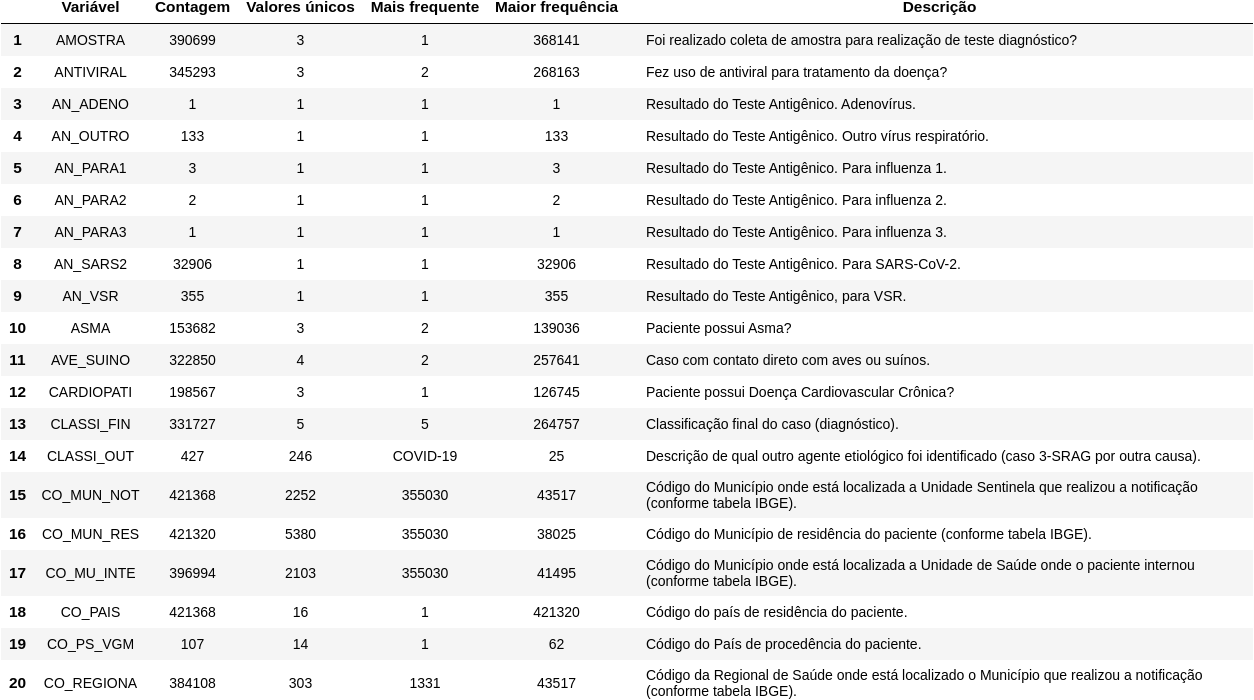

In [32]:
start_index = 0
rows = 20
show_table(df_desc,cat_nom,start_index,rows)

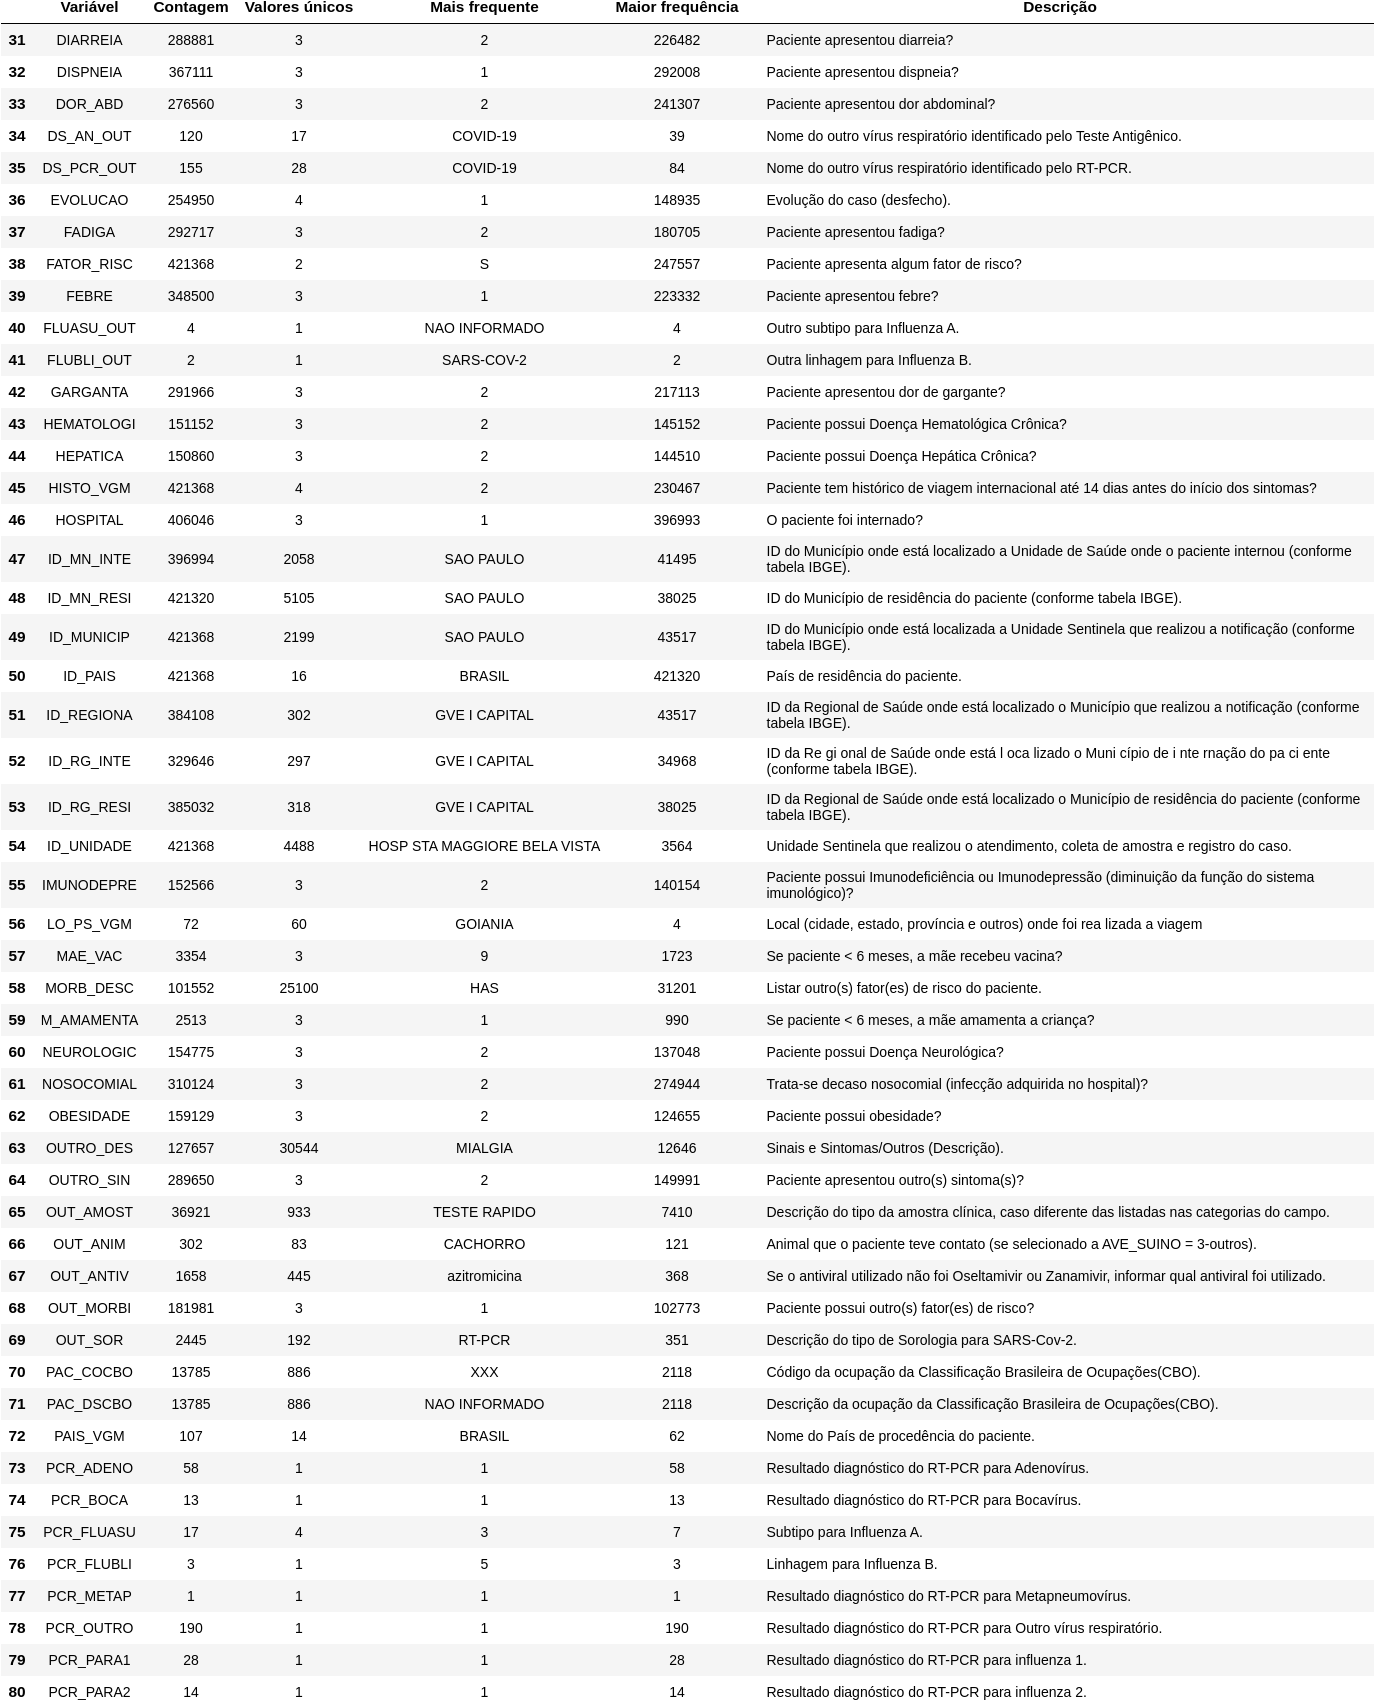

In [6]:
start_index += rows
rows = 50
show_table(df_desc,cat_nom,start_index,rows)

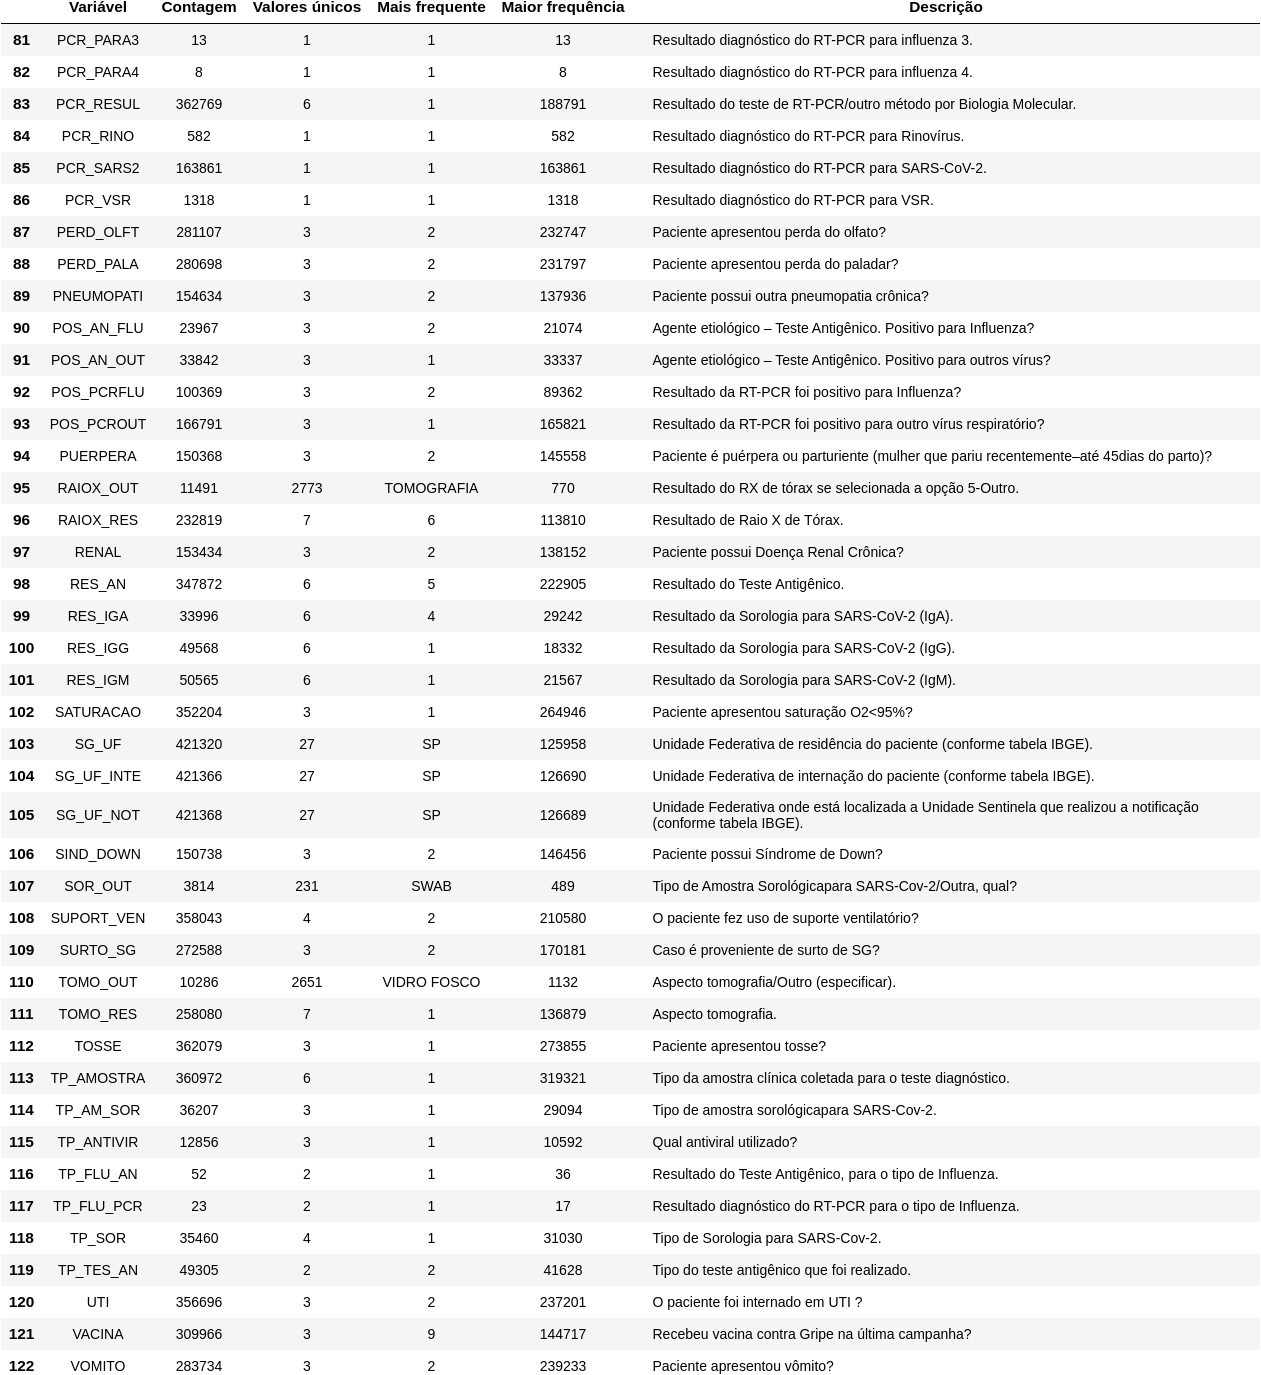

In [7]:
start_index += rows
show_table(df_desc,cat_nom,start_index,rows=None)

A seguir, um exemplo de historama para a variável 'PAIS_VGM' (Nome do País de procedência do paciente.):

<AxesSubplot:ylabel='PAIS_VGM'>

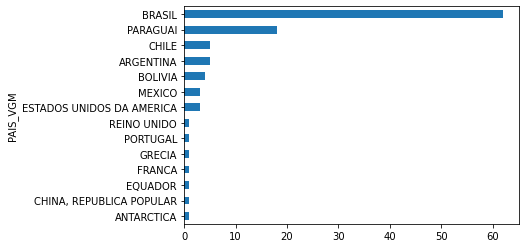

In [8]:
col = 'PAIS_VGM'
x = df_srag[[col]]#.astype(float)
x
values_cols = 'DT_SIN_PRI'
x = df_srag.groupby(by=col)[values_cols].count().sort_values(ascending=True)
ax = x.plot.barh()

<div style=”page-break-after: always;”></div>

## Variáveis qualitativas ordinais


Número de variáveis: 5




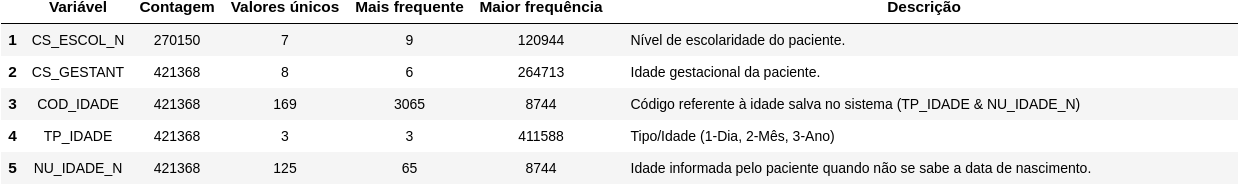

In [9]:
print(f'\nNúmero de variáveis: {len(cat_ord)}\n\n')
show_table(df_desc,cat_ord)

A seguir, um exemplo de historama para a variável 'CS_ESCOL_N' (Nível de escolaridade do paciente):

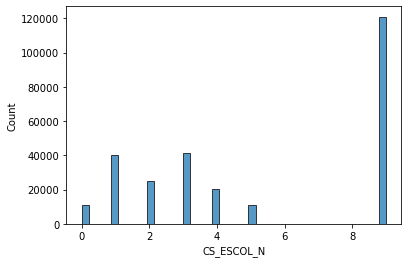

In [10]:
col = 'CS_ESCOL_N'
x = df_srag[col].astype(float)
ax = sns.histplot(data=x,discrete=False)

## Variáveis quantitativas discretas


Número de variáveis: 2




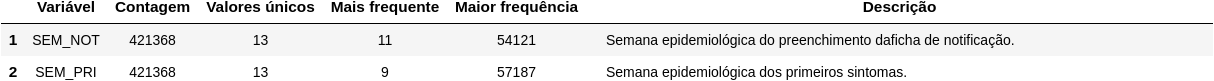

In [11]:
print(f'\nNúmero de variáveis: {len(num_disc)}\n\n')
show_table(df_desc,num_disc)

A seguir, um exemplo de historama para a variável 'SEM_PRI' (Semana epidemiológica dos primeiros sintomas):

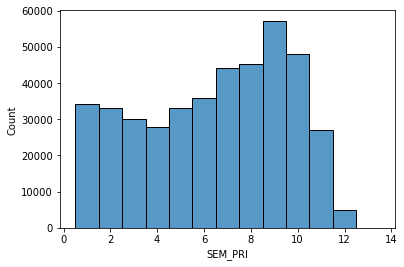

In [12]:
col = 'SEM_PRI'
x = df_srag[col].astype(int)
ax = sns.histplot(data=x,discrete=True)

<div style="page-break-after: always;"></div>

## Variáveis quantitativas contínuas


Número de variáveis: 1




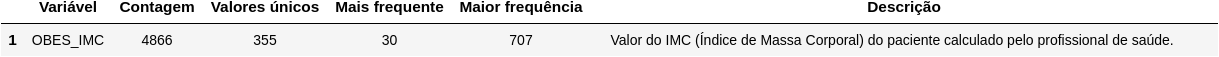

In [13]:
print(f'\nNúmero de variáveis: {len(num_cont)}\n\n')
show_table(df_desc,num_cont)

A seguir, um exemplo de historama para a variável 'OBES_IMC' (Valor do Índice de Massa Corporal do paciente calculado pelo profissional de saúde):

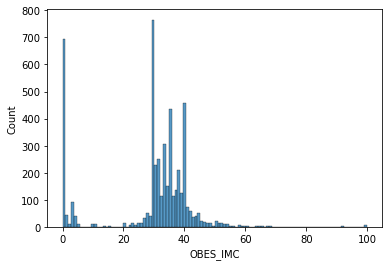

In [14]:
col = 'OBES_IMC'
x = df_srag[col].str.replace(',','.').astype(float)
ax = sns.histplot(data=x,discrete=False)

<div style="page-break-after: always;"></div>

### Variáveis de datas

Existem 24 variǘeis com informações referentes a datas. Acredito que essas variáveis possuem características um pouco diferentes das demais, por isso achei que seria interessante criar uma "subcategoria". Segundo minha interpretação, as variáveis do tipo data podem ser classificadas em tipos diferentes, a depender da análise que será realizada. A princípio, trataremos essas variáveis como numéricas, ou seja, como uma medida do tempo em que determinado evento ocorreu.

Além disso, apesar das datas se referirem apenas a dias "inteiros", como as séries analisadas são muito extensas, algumas com milhares de datas, trataremos essas variáveis como contínua. Por isso, entendemos que a melhor classificação para essas seria como "variáveis quantitativas contínuas".


Número de variáveis: 24




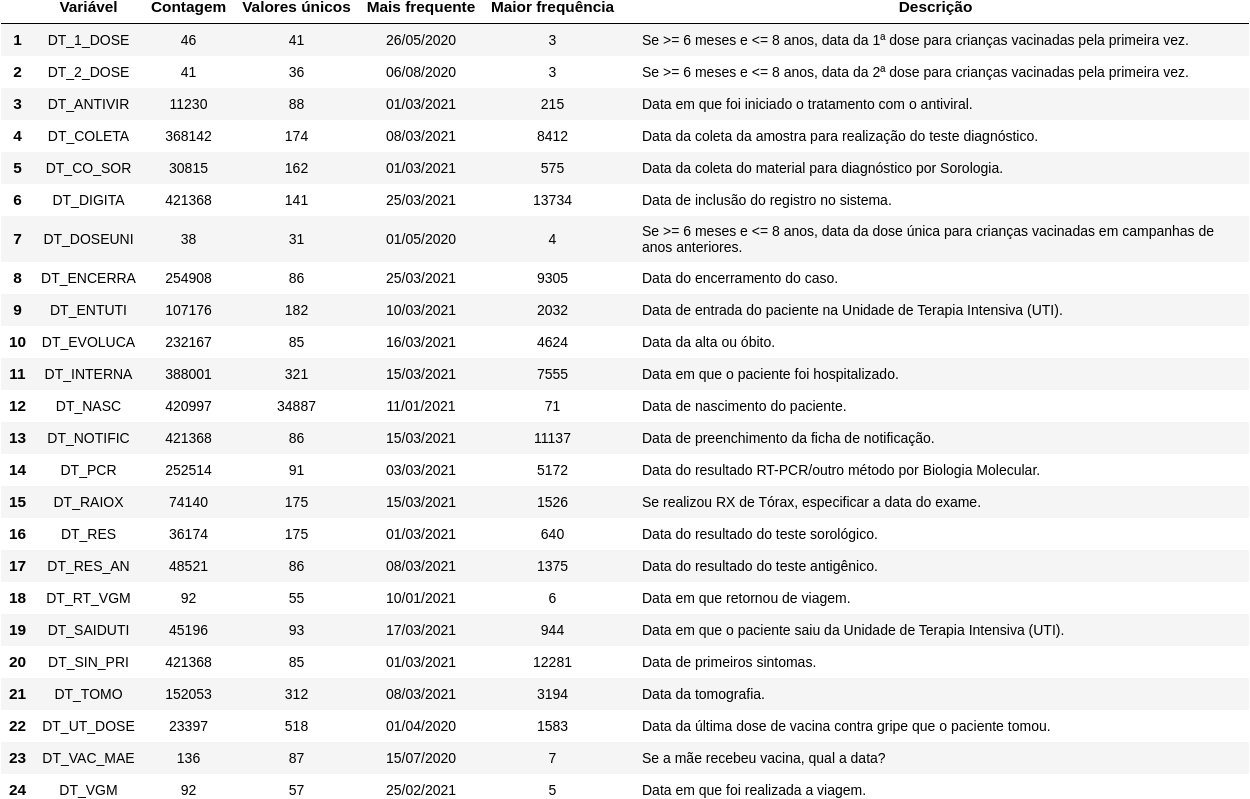

In [15]:
print(f'\nNúmero de variáveis: {len(dates_var)}\n\n')
show_table(df_desc,dates_var)

<div style="page-break-after: always;"></div>

A seguir, um exemplo de historama para a variável 'DT_NASC' (Data de nascimento do paciente):

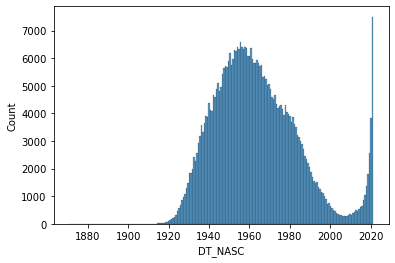

In [16]:
col = 'DT_NASC'
x = pd.to_datetime(df_srag[col], errors='coerce',dayfirst=True)
ax = sns.histplot(data=x,discrete=False)

# Missing Data

- há missing data? quantos? em quais variáveis? 

In [33]:
df = df_desc.copy()
df['Missing'] = df_srag.shape[0] - df['Contagem']
cols = list(df.columns)
cols = cols[-1:] + cols[:-1]
df = df[cols]
# df = df[['missing']]
df = df.query('Missing > 0')
df = df.sort_values(by='Missing',ascending=False)

print(f'\nNúmero de variáveis com missing values: {len(df)}\n\n')


Número de variáveis com missing values: 134




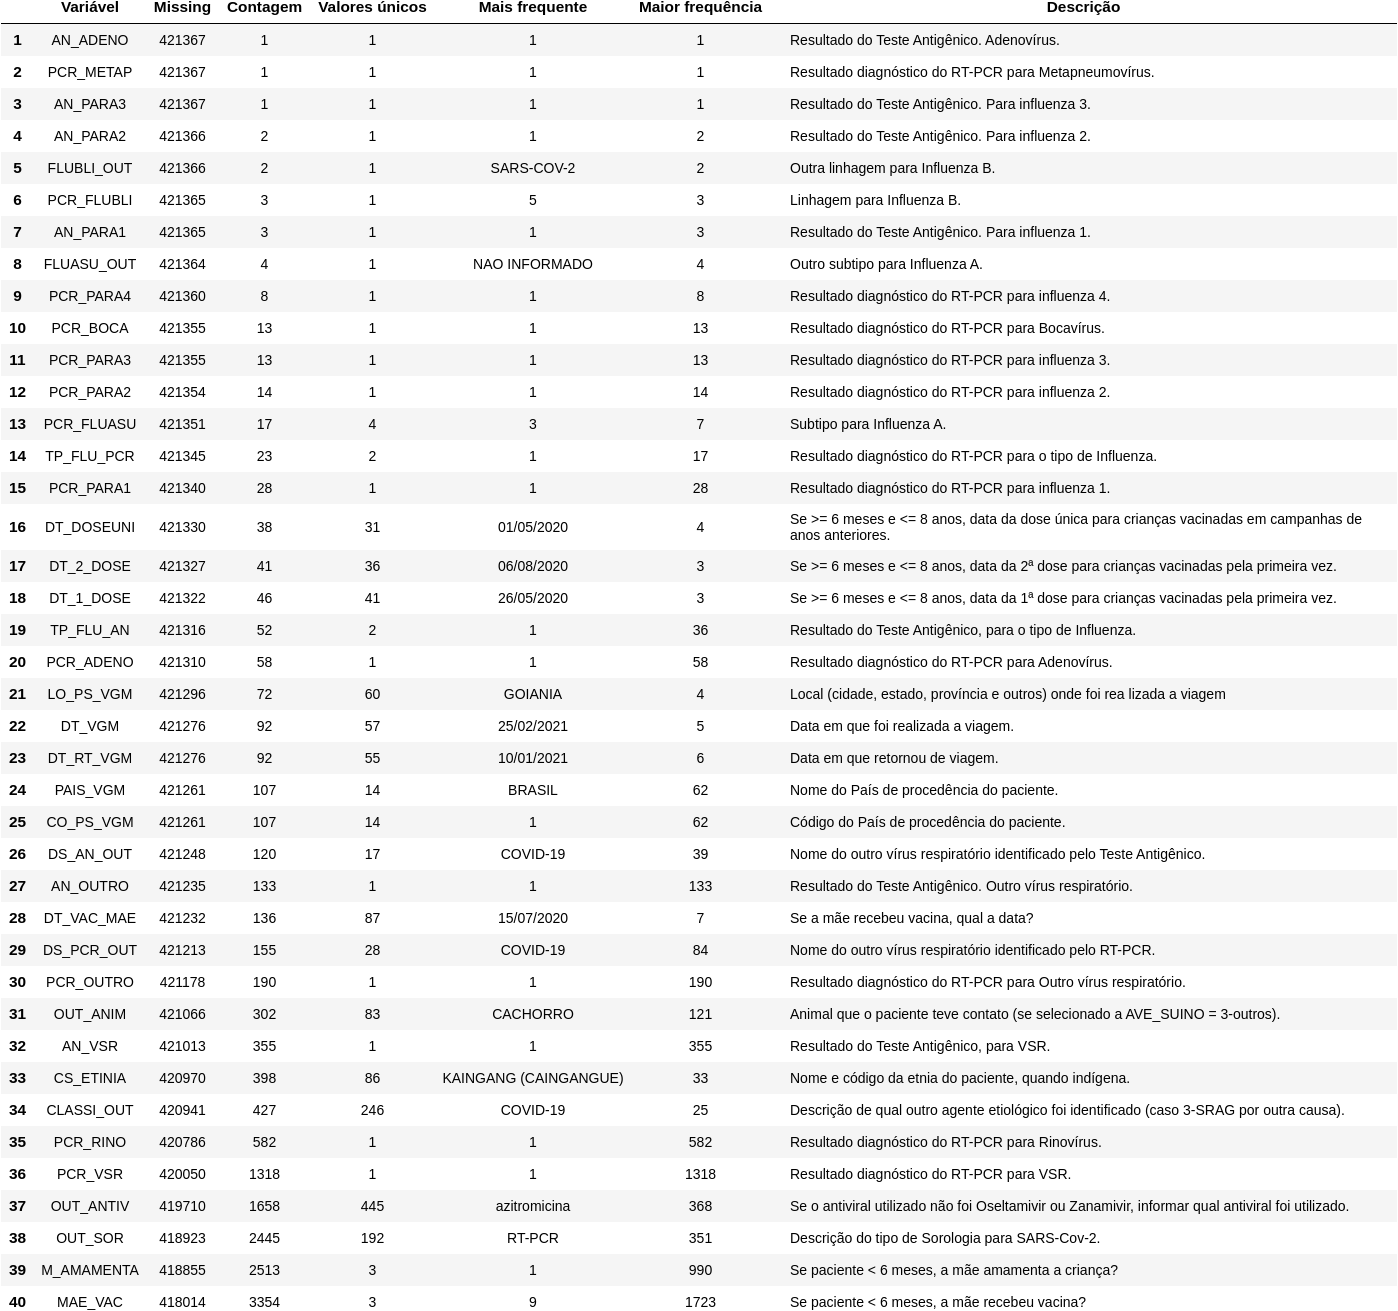

In [34]:
start_index = 0
rows = 40
show_table(df,list(df.index),start_index,rows)

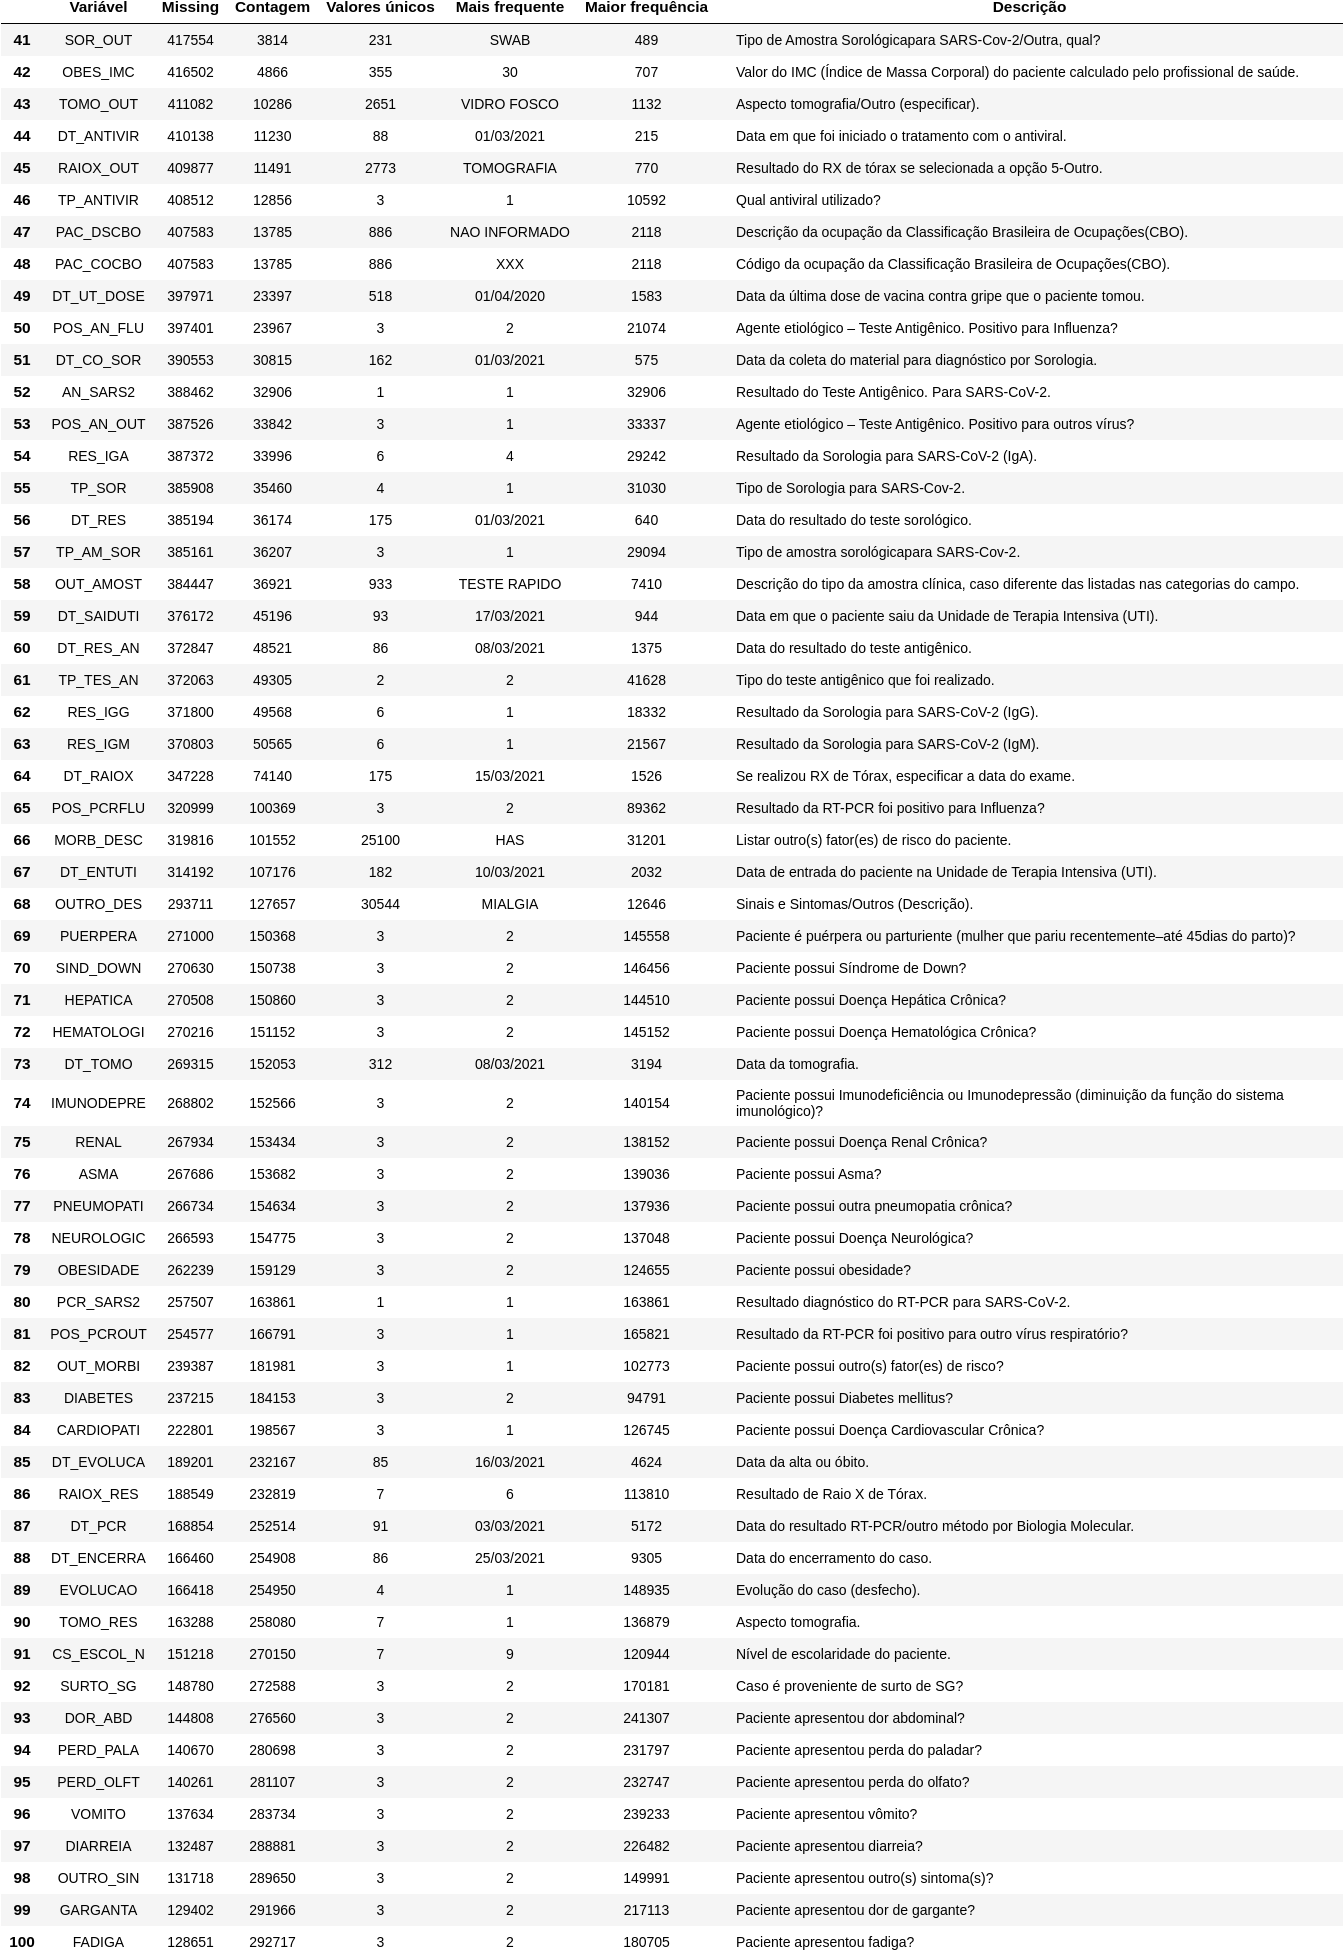

In [35]:
start_index += rows
rows = 60
show_table(df,list(df.index),start_index,rows)

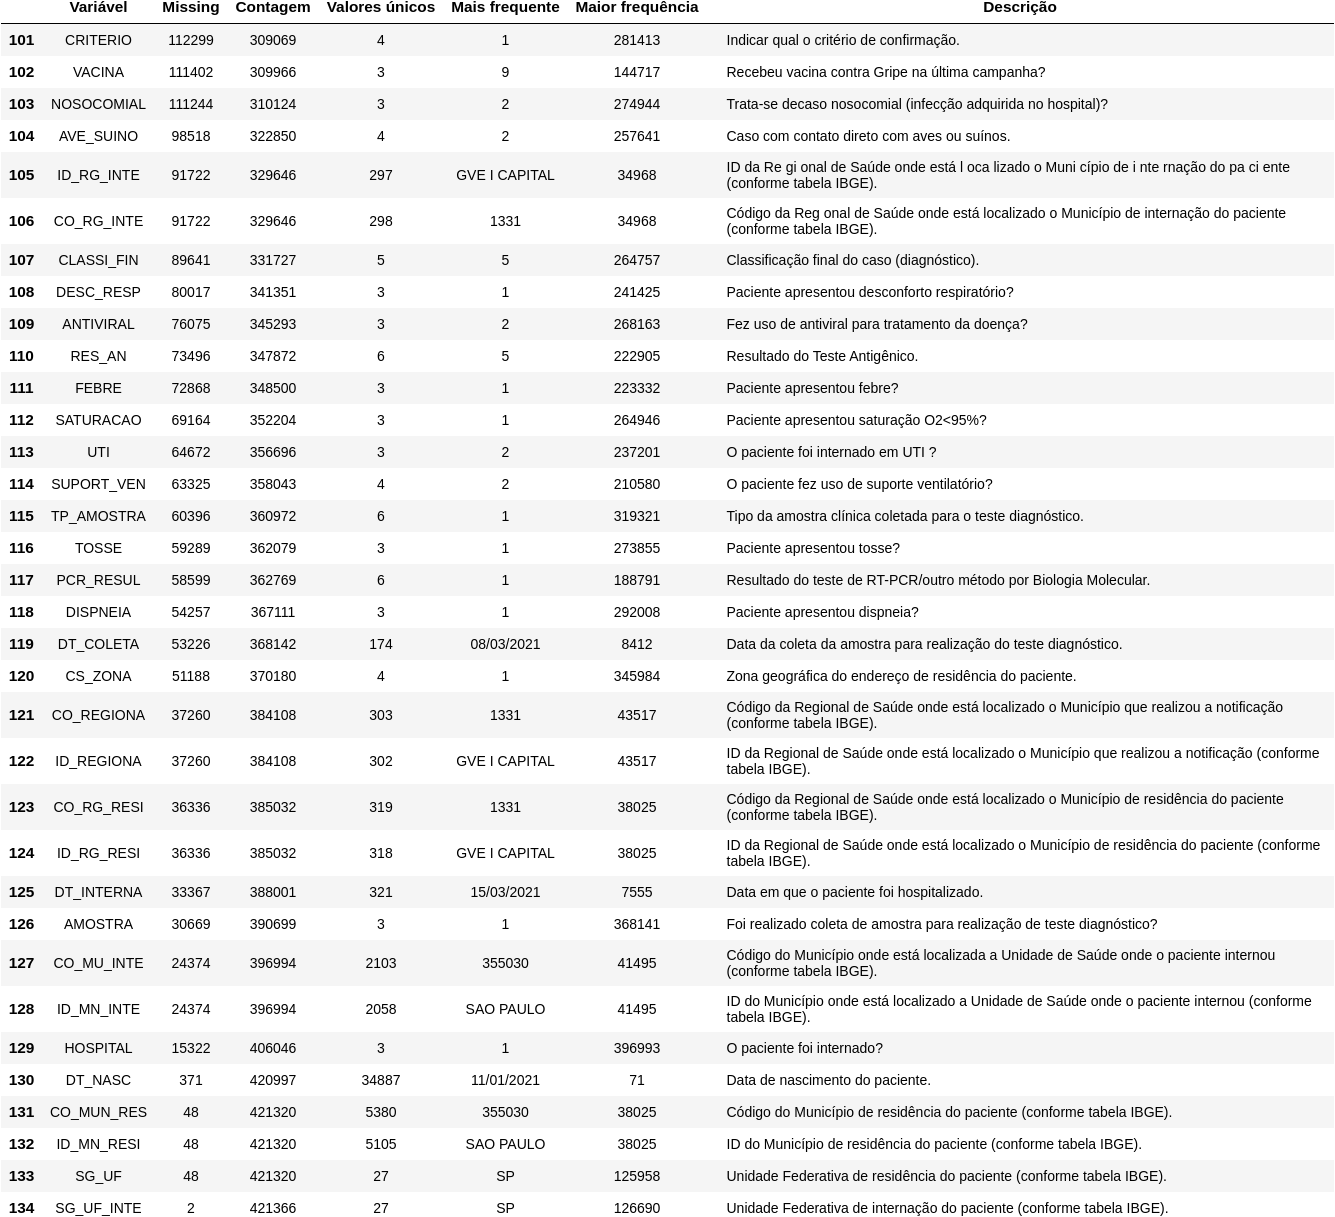

In [36]:
start_index += rows
show_table(df,list(df.index),start_index)

In [21]:
# # dfg = df.groupby()
# import seaborn as sns
# col = list(cols)[11]
# df[col] = pd.to_datetime(df[col], errors='coerce',dayfirst=True)
# print(df[col].nunique())

# # df[col].count()
# x = df.groupby(by=col)[['DT_NOTIFIC']].count().reset_index()
# xmin = max(pd.to_datetime('2021-01-01'),df[col].min())
# xmax = min(pd.to_datetime('2021-04-01'),df[col].max())

# x = x.loc[x[col]>=xmin]
# x = x.loc[x[col]<=xmax]
# x.plot.scatter(x=col,y='DT_NOTIFIC',xlim = (xmin,xmax))
# # x
# # sns.histplot(data=x,x=col)#,y='DT_NOTIFIC')

In [22]:
import PyPDF2
import glob
import pathlib # substitui a os.path
import sys
#from tika import parser

def read_pdf_text_contents(file_name):
    page_content = ""
    read_pdf = PyPDF2.PdfFileReader(file_name)
    for page in read_pdf.pages:
        page_content += page.extractText()
    return page_content

def find_strings(fileName,key_strings):
    content = read_pdf_text_contents(fileName)
    if content.strip():
        for key_string in key_strings:
            if key_string in content:
                return('Bingo!')
        ## if not found
        return('Strings não encontradas.')

    else:
        return('Nenhum texto lido: avaliar imagem.')
    
# sep_key = '$$$'
# str_file = file_content.replace('\n','')
# key = df_srag.columns[0]

# out_str = ''
# words = file_content.split()
# for word in words:
#     if word in df_srag.columns:
#         word += sep_key
#     out_str += word + ' '
# #     for key in df_srag.columns:
# #         words = file_content.split()
    
# #     str_file = str_file.replace(key,key+sep_key)
# #     print(key+sep_key)
# lines = str_file.split(sep_key)
# len(lines)
# # lines[:]
# # file_content
# words = file_content.split()
# key in words#.find(key)
# # key
# lines = out_str.split(sep_key)
# len(lines)
# lines[9]

In [39]:
df_head = df_srag.head(1000)
fname = 'victormarchesini_dataset1_amostra.csv'
df_head.to_csv(fname,index=False)

In [23]:
# # Referências

# ## Is time nominal, ordinal, interval or ratio? Is it categorical or continuous? 
# https://statisticalanalysisconsulting.com/is-time-nominal-ordinal-interval-or-ratio-is-it-categorical-or-continuous/


# ## What is the difference between ordinal, interval and ratio variables? Why should I care?
# https://www.graphpad.com/support/faq/what-is-the-difference-between-ordinal-interval-and-ratio-variables-why-should-i-care/
    
